In [1]:
import numpy as np
import math
import os
import pandas as pd
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.io import fits
from marvin.tools.cube import Cube
from astropy import wcs
from matplotlib import cm
from Ellipse_redshift_functions import * #This imports all the functions needed to compute the ellipse
os.environ['SAS_BASE_DIR'] = #Using a local folder with MaNGA data 

[INFO]: No release version set. Setting default to DR17


In [2]:
file_path = #Add your path to the MaNGA data 'dr17/manga/spectro/redux/v3_1_1/' was used here

In [3]:
def set_plot_style(ax, title=None):
    ax.set_xlim(-10.1, 10)
    ax.set_ylim(-10.1, 10)
    ax.tick_params(labelsize=20)
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
    
    # Set labels and title
    ax.set_xlabel('arcsec', fontsize=20)
    ax.set_ylabel('arcsec', fontsize=20)
    if title:
        ax.set_title(title, fontsize=20)
        
    

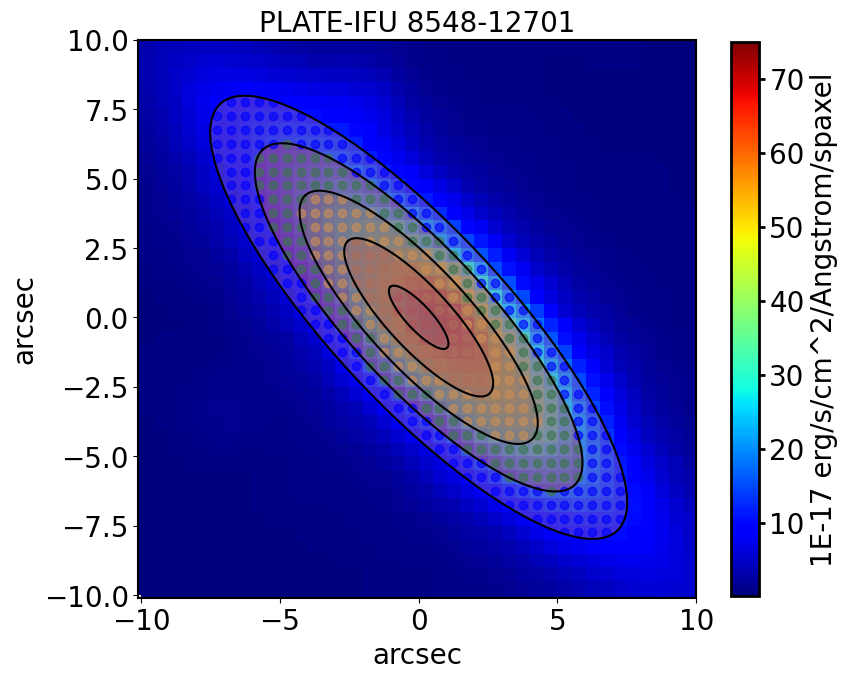

In [4]:
spectra = '8548-12701'
    
#path to your MaNGA cube for '8548-12701'

file = file_path + '{}/stack/manga-{}-LOGCUBE.fits.gz'.format(spectra.split('-')[0], spectra)
cube = fits.open(file)

flux = np.transpose(cube['FLUX'].data, axes=(2, 1, 0))
ivar = np.transpose(cube['IVAR'].data, axes=(2, 1, 0))
mask = np.transpose(cube['MASK'].data, axes=(2, 1, 0))

wave = cube['WAVE'].data

flux_header = cube['FLUX'].header

x_center = int(flux_header['CRPIX1']) - 1

y_center = int(flux_header['CRPIX2']) - 1


cubeWCS = wcs.WCS(flux_header)

do_not_use = (mask & 2**10) != 0 #warnings

flux_m = np.ma.array(flux, mask=do_not_use) #flux map

redshift = 0.05798

ind_wave = np.where((wave / (1 + redshift) > 6550) & (wave / (1 + redshift) < 6680))[0]

halpha = flux_m[:, :, ind_wave].sum(axis=2)

im = halpha.T

dx = flux_header['CD1_1'] * 3600.  # deg to arcsec

dy = flux_header['CD2_2'] * 3600.  # deg to arcsec

x_extent = (np.array([0., im.shape[0]]) - (im.shape[0] - x_center)) * dx * (-1)

y_extent = (np.array([0., im.shape[1]]) - (im.shape[1] - y_center)) * dy

extent = [x_extent[0], x_extent[1], y_extent[0], y_extent[1]]


#axis ratio (ba) and position angle (phi) can be obtained from the catalogue

ba = 0.300108

phi = 42.9084

cube = Cube(plateifu = spectra)

radii = radii = [1.5, 3.75, 6, 8.25, 10.50, 13]

major_axis = np.asarray(radii)

axis_ratio = ba

minor_axis = axis_ratio * major_axis

test = Ellipse_(int(np.max(major_axis) + 0.5), int(np.max(major_axis) + 0.5))

position_angle = 90+phi

for counter, x_p in enumerate(major_axis):
    X_v = []; Y_v = []
    for pc, a_v in enumerate(major_axis):

        if pc == 0 :

            a = ploting_annulus_points(test[0], test[1], 0, 0, a_v, minor_axis[pc], 0, 0, position_angle)
            X_v.append(list(zip(a[0], a[1])))

        else: 

            a = ploting_annulus_points(test[0], test[1], 0, 0, major_axis[pc-1], minor_axis[pc-1],
                                   a_v, minor_axis[pc], position_angle)
            X_v.append(list(zip(a[0], a[1])))

annulus_region = remove_common_coordinates (X_v)

fig, ax = plt.subplots( figsize = (9,9))

set_plot_style(ax)

colour = ['red', 'orange', 'yellow', 'green', 'blue']
a_lpha = [0.6, 0.6, 0.5, 0.4, 0.3]
for pcount, xvalues in enumerate(annulus_region[0]):

    if pcount < 5: #this limits the number of annulus regions to 5 for illustration purposes
        x, y = ellipse_points(0, 0,  major_axis[pcount], minor_axis[pcount], position_angle)
        plt.plot(x, y, color = 'black')
        plt.fill_between(x,y, alpha = 0.4)
        plt.scatter(xvalues, annulus_region[1][pcount], color = colour[pcount], alpha = 0.6)


plt.imshow(im, extent=extent, cmap='jet', vmin=0.1, vmax=75, origin='lower', interpolation='none')

cbar = plt.colorbar(shrink=0.8)
cbar.outline.set_color('black')
cbar.outline.set_linewidth(2)
cbar.ax.tick_params(labelsize=20, width=2, length = 4)

cbar.ax.set_ylabel(flux_header['BUNIT'], fontsize = 20)

plt.xlabel('arcsec', fontsize = 20)
plt.ylabel('arcsec', fontsize = 20)
plt.title('PLATE-IFU {}'.format(spectra), fontsize = 20)
plt.show()